In [170]:
# Importing the relevant libraries
import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score,  cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, 
    average_precision_score
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
from sklearn.preprocessing import StandardScaler
from collections import Counter
from datetime import datetime, timedelta

In [173]:
# SQL Query
conn = pyodbc.connect(
    f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};Encrypt=yes'
)

cursor = conn.cursor()

query = """
WITH
/* ---------------------------------------------------------
   1. Latest Review Per Order
--------------------------------------------------------- */
LatestReview AS (
    SELECT order_id, review_score
    FROM (
        SELECT 
            r.order_id, 
            r.review_score,
            ROW_NUMBER() OVER (
                PARTITION BY r.order_id
                ORDER BY r.review_creation_date DESC
            ) AS rn
        FROM Reviews_Dataset r
        JOIN Orders_Dataset o
            ON r.order_id = o.order_id
        WHERE r.review_creation_date >= o.order_approved_at  -- we only consider reviews after order approval
    ) t
    WHERE rn = 1
),


/* ---------------------------------------------------------
   2. Items Aggregated Per Order
--------------------------------------------------------- */
OrderItems AS (
    SELECT 
        order_id,
        COUNT(order_item_id) AS number_of_items,
        SUM(price) AS total_order_price,
        SUM(freight_value) AS total_freight
    FROM Items_Dataset
    GROUP BY order_id
),

/* ---------------------------------------------------------
   3. Customer Information (joined once)
--------------------------------------------------------- */
CustomerData AS (
    SELECT 
        C.customer_id,
        C.customer_zip_code_prefix,
        CITY.city
    FROM Customers_Dataset C
    LEFT JOIN Cities_Dataset CITY 
        ON C.customer_zip_code_prefix = CITY.zip_code
),

/* ---------------------------------------------------------
   4. Historical ZIP-Level Delivery Stats
--------------------------------------------------------- */
ZipStats AS (
    SELECT
        O.order_id,
        C.customer_zip_code_prefix,
        COUNT(*) OVER (
            PARTITION BY C.customer_zip_code_prefix
            ORDER BY O.order_approved_at, O.order_id
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS orders_zip_code_count,
        AVG(DATEDIFF(DAY,
            O.order_estimated_delivery_date,
            O.order_delivered_customer_date
        )) OVER (
            PARTITION BY C.customer_zip_code_prefix
            ORDER BY O.order_approved_at, O.order_id
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS avg_delay_zip
    FROM Orders_Dataset O
    JOIN Customers_Dataset C ON O.customer_id = C.customer_id
    WHERE O.order_delivered_customer_date IS NOT NULL
),

/* ---------------------------------------------------------
   5. Historical City-Level Delivery Stats
--------------------------------------------------------- */
CityStats AS (
    SELECT
        O.order_id,
        CITY.city,
        COUNT(*) OVER (
            PARTITION BY CITY.city
            ORDER BY O.order_approved_at, O.order_id
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS orders_city_count,
        AVG(DATEDIFF(DAY,
            O.order_estimated_delivery_date,
            O.order_delivered_customer_date
        )) OVER (
            PARTITION BY CITY.city
            ORDER BY O.order_approved_at, O.order_id
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS avg_delay_city
    FROM Orders_Dataset O
    JOIN Customers_Dataset C ON O.customer_id = C.customer_id
    JOIN Cities_Dataset CITY ON C.customer_zip_code_prefix = CITY.zip_code
    WHERE O.order_delivered_customer_date IS NOT NULL
),

/* ---------------------------------------------------------
   6. Seller-Level Static Aggregations
--------------------------------------------------------- */
SellerProductVariety AS (
    SELECT seller_id, COUNT(DISTINCT product_id) AS product_variety
    FROM Items_Dataset
    GROUP BY seller_id
),
SellerAvgProductPrice AS (
    SELECT seller_id, AVG(price) AS avg_product_price
    FROM Items_Dataset
    GROUP BY seller_id
),

/* ---------------------------------------------------------
   7. Product Metadata
--------------------------------------------------------- */
ProductMeta AS (
    SELECT 
        product_id,
        product_description_lenght,
        product_photos_qty
    FROM Products_Dataset
),

/* ---------------------------------------------------------
   8. Item-Level Enrichment
--------------------------------------------------------- */
ItemEnriched AS (
    SELECT 
        I.order_id,
        I.seller_id,
        I.product_id,
        P.product_description_lenght,
        P.product_photos_qty,
        SPV.product_variety,
        SPP.avg_product_price
    FROM Items_Dataset I
    LEFT JOIN ProductMeta P ON I.product_id = P.product_id
    LEFT JOIN SellerProductVariety SPV ON I.seller_id = SPV.seller_id
    LEFT JOIN SellerAvgProductPrice SPP ON I.seller_id = SPP.seller_id
),

/* ---------------------------------------------------------
   9. Seller Historical Metrics (Leak-Safe)
--------------------------------------------------------- */
SellerMetrics AS (
    SELECT
        i.order_id,
        i.seller_id,

        SUM(CASE WHEN lr.review_score IN (1,2) THEN 1 ELSE 0 END)
            OVER (
                PARTITION BY i.seller_id
                ORDER BY o.order_approved_at, o.order_id
                ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
            ) AS bad_review_count,

        COALESCE(
            CAST(SUM(CASE WHEN o.order_status = 'canceled' THEN 1 ELSE 0 END)
                OVER (
                    PARTITION BY i.seller_id
                    ORDER BY o.order_approved_at, o.order_id
                    ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
                ) AS FLOAT)
            /
            NULLIF(CAST(COUNT(*)
                OVER (
                    PARTITION BY i.seller_id
                    ORDER BY o.order_approved_at, o.order_id
                    ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
                ) AS FLOAT), 0),
            0
        ) AS cancellation_ratio,

        STDEV(DATEDIFF(
            DAY,
            o.order_estimated_delivery_date,
            o.order_delivered_customer_date
        )) OVER (
            PARTITION BY i.seller_id
            ORDER BY o.order_approved_at, o.order_id
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS delay_std

    FROM ItemEnriched i
    JOIN Orders_Dataset o ON i.order_id = o.order_id
    LEFT JOIN LatestReview lr ON i.order_id = lr.order_id
    WHERE o.order_delivered_customer_date IS NOT NULL
),

/* ---------------------------------------------------------
   10. Product Historical Bad Review Metrics (Leak-Safe)
--------------------------------------------------------- */
ProductMetrics AS (
    SELECT
        i.order_id,
        i.product_id,
        SUM(CASE WHEN lr.review_score IN (1,2) THEN 1 ELSE 0 END)
            OVER (
                PARTITION BY i.product_id
                ORDER BY o.order_approved_at, o.order_id
                ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
            ) AS bad_review_count_product
    FROM ItemEnriched i
    JOIN Orders_Dataset o ON i.order_id = o.order_id
    LEFT JOIN LatestReview lr ON i.order_id = lr.order_id
    WHERE o.order_delivered_customer_date IS NOT NULL
),

/* ---------------------------------------------------------
   11. Aggregate Product Bad Review Metrics
--------------------------------------------------------- */
ProductHistoryAgg AS (
    SELECT
        order_id,
        AVG(bad_review_count_product) AS avg_product_bad_reviews
    FROM ProductMetrics
    GROUP BY order_id
),

/* ---------------------------------------------------------
   12. Product Historical Sales Count (Leak-Safe)
--------------------------------------------------------- */
ProductSalesHistory AS (
    SELECT
        i.order_id,
        i.product_id,
        COUNT(*) OVER (
            PARTITION BY i.product_id
            ORDER BY o.order_approved_at, o.order_id
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS past_product_sales
    FROM ItemEnriched i
    JOIN Orders_Dataset o ON i.order_id = o.order_id
),

/* ---------------------------------------------------------
   13. Aggregate Product Sales Per Order
--------------------------------------------------------- */
ProductSalesAgg AS (
    SELECT
        order_id,
        AVG(past_product_sales) AS avg_product_sales_history
    FROM ProductSalesHistory
    GROUP BY order_id
),

/* ---------------------------------------------------------
   14. Aggregate ItemEnriched Per Order
--------------------------------------------------------- */
ItemAggregates AS (
    SELECT 
        order_id,
        AVG(product_description_lenght) AS avg_description_length,
        AVG(product_photos_qty) AS avg_image_count,
        AVG(product_variety) AS avg_seller_variety,
        AVG(avg_product_price) AS avg_seller_price,
        COUNT(DISTINCT seller_id) AS seller_count
    FROM ItemEnriched
    GROUP BY order_id
),

/* ---------------------------------------------------------
   15. Aggregate Seller Metrics Per Order
--------------------------------------------------------- */
SellerHistoryAgg AS (
    SELECT
        order_id,
        AVG(bad_review_count) AS avg_bad_reviews,
        AVG(cancellation_ratio) AS avg_cancellation_ratio,
        AVG(delay_std) AS avg_delay_std
    FROM SellerMetrics
    GROUP BY order_id
)

---------------------------------------------------------
--   FINAL SELECT
---------------------------------------------------------
SELECT
    O.order_estimated_delivery_date,
    DATEDIFF(DAY, O.order_approved_at, O.order_estimated_delivery_date) AS estimated_lead_time,
    DATEDIFF(DAY, O.order_estimated_delivery_date, O.order_delivered_customer_date) AS delay,
    COALESCE(
        NULLIF(
            CAST(DATEDIFF(
                DAY,
                O.order_estimated_delivery_date,
                O.order_delivered_customer_date
            ) AS FLOAT) /
            NULLIF(DATEDIFF(
                DAY,
                O.order_approved_at,
                O.order_estimated_delivery_date
            ), 0),
        0),
    0) AS delay_ratio,

    PAY.payment_type,
    R.review_score,
    I.total_order_price,
    I.total_freight,
    I.total_freight / NULLIF(I.total_order_price, 0) AS freight_to_price_ratio,

    ZIP.orders_zip_code_count,
    ZIP.avg_delay_zip,
    COALESCE(CITY.orders_city_count,0) AS orders_city_count,
    CITY.avg_delay_city,

    IA.seller_count,
    IA.avg_description_length,
    IA.avg_image_count,
    IA.avg_seller_variety,
    IA.avg_seller_price,

    COALESCE(SH.avg_bad_reviews,0) AS avg_bad_reviews,
    SH.avg_cancellation_ratio,
    SH.avg_delay_std,

    COALESCE(PH.avg_product_bad_reviews, 0) AS avg_product_bad_reviews,
    COALESCE(PSA.avg_product_sales_history, 0) AS avg_product_sales_history,

    I.number_of_items,
    (I.total_order_price * IA.seller_count * I.number_of_items) AS order_complexity

FROM Orders_Dataset O
INNER JOIN LatestReview R ON O.order_id = R.order_id
INNER JOIN OrderItems I ON O.order_id = I.order_id
LEFT JOIN CustomerData CD ON O.customer_id = CD.customer_id
LEFT JOIN ZipStats ZIP ON O.order_id = ZIP.order_id
LEFT JOIN CityStats CITY ON O.order_id = CITY.order_id
LEFT JOIN ItemAggregates IA ON O.order_id = IA.order_id
LEFT JOIN SellerHistoryAgg SH ON O.order_id = SH.order_id
LEFT JOIN ProductHistoryAgg PH ON O.order_id = PH.order_id
LEFT JOIN ProductSalesAgg PSA ON O.order_id = PSA.order_id
INNER JOIN Payments_Dataset PAY ON PAY.order_id = O.order_id

WHERE 
      PAY.payment_sequential = 1
  AND O.order_delivered_customer_date IS NOT NULL
  AND O.order_approved_at IS NOT NULL
  AND O.order_estimated_delivery_date IS NOT NULL
  AND O.order_status = 'delivered'
  AND R.review_score != 3;


"""

df = pd.read_sql_query(query, conn)

print(df.head())


conn.close()


C:\Users\airun\AppData\Local\Temp\ipykernel_25004\2270457640.py:357: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


  order_estimated_delivery_date  estimated_lead_time  delay  delay_ratio  \
0                    2017-09-29                   16     -9    -0.562500   
1                    2017-05-15                   19     -3    -0.157895   
2                    2018-02-05                   22    -14    -0.636364   
3                    2018-08-20                   12     -6    -0.500000   
4                    2017-03-17                   41    -16    -0.390244   

  payment_type  review_score  total_order_price  total_freight  \
0  credit_card             5             5890.0         1329.0   
1  credit_card             4            23990.0         1993.0   
2  credit_card             5            19900.0         1787.0   
3  credit_card             4             1299.0         1279.0   
4  credit_card             5            19990.0         1814.0   

   freight_to_price_ratio  orders_zip_code_count  ...  avg_image_count  \
0                0.225637                      5  ...              4.0  

In [174]:
# We create a new variable to account for wether customers behave differently in terms of the review scores
# in specific dates (prior to holidadys associated with gifts in Brazil).

df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"], errors="coerce")

# Years covered in your dataset
years = [2016, 2017, 2018]

# Helper functions
def second_sunday(year, month):
    """Return date of the 2nd Sunday of a given month/year."""
    d = datetime(year, month, 1)
    while d.weekday() != 6:  # find first Sunday
        d += timedelta(days=1)
    return (d + timedelta(days=7)).date()  # second Sunday

def black_friday(year):
    """Return Black Friday date (4th Friday of November)."""
    d = datetime(year, 11, 1)
    while d.weekday() != 4:  # find first Friday
        d += timedelta(days=1)
    return (d + timedelta(weeks=3)).date()  # 4th Friday

# Easter dates for 2016–2018 (precomputed)
easter_dates = {
    2016: datetime(2016, 3, 27).date(),
    2017: datetime(2017, 4, 16).date(),
    2018: datetime(2018, 4, 1).date()
}

# Build consumption-related holidays for each year
consumption_holidays = []
for y in years:
    consumption_holidays.extend([
        datetime(y, 12, 25).date(),        # Christmas
        second_sunday(y, 5),               # Mother's Day
        datetime(y, 6, 12).date(),         # Valentine's Day
        easter_dates[y],                   # Easter Sunday
        second_sunday(y, 8),               # Father's Day
        black_friday(y)                    # Black Friday
    ])

# Build 1-week windows prior to each holiday
holiday_windows = [(h - timedelta(days=7), h) for h in consumption_holidays]

# Function to check if a date falls in any holiday window
def in_consumption_window(date):
    if pd.isnull(date):
        return False
    d = date.date()
    return any(start <= d <= end for start, end in holiday_windows)

# Create dummy variable
df["is_pre_consumption_holiday"] = df["order_estimated_delivery_date"].apply(in_consumption_window)




In [175]:
# We examine the unique and null values in our features

for i, col in enumerate(df.columns):
    print(col, df[col].nunique(), df[col].isna().sum())


print(df.shape)

order_estimated_delivery_date 443 0
estimated_lead_time 99 0
delay 192 0
delay_ratio 1739 0
payment_type 4 0
review_score 4 0
total_order_price 7106 0
total_freight 7210 0
freight_to_price_ratio 40491 0
orders_zip_code_count 136 0
avg_delay_zip 144 13458
orders_city_count 14340 0
avg_delay_city 104 2154
seller_count 5 0
avg_description_length 2920 1236
avg_image_count 19 1236
avg_seller_variety 233 0
avg_seller_price 3652 0
avg_bad_reviews 386 0
avg_cancellation_ratio 939 0
avg_delay_std 77257 4349
avg_product_bad_reviews 88 0
avg_product_sales_history 516 0
number_of_items 16 0
order_complexity 8005 0
is_pre_consumption_holiday 2 0
(87804, 26)


In [176]:
# As one of my variables is a categorical variable I get dummies
df = pd.get_dummies(df)
df.head()

,order_estimated_delivery_date,estimated_lead_time,delay,delay_ratio,review_score,total_order_price,total_freight,freight_to_price_ratio,orders_zip_code_count,avg_delay_zip,...,avg_delay_std,avg_product_bad_reviews,avg_product_sales_history,number_of_items,order_complexity,is_pre_consumption_holiday,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,2017-09-29,16,-9,-0.562500,5,5890.0,1329.0,0.225637,5,-14.0,...,11.418931,1,6,1,5890.0,False,False,True,False,False
1,2017-05-15,19,-3,-0.157895,4,23990.0,1993.0,0.083076,1,-26.0,...,NaN,0,0,1,23990.0,False,False,True,False,False
2,2018-02-05,22,-14,-0.636364,5,19900.0,1787.0,0.089799,9,-12.0,...,4.810702,0,2,1,19900.0,False,False,True,False,False
3,2018-08-20,12,-6,-0.500000,4,1299.0,1279.0,0.984604,5,-8.0,...,7.250995,0,0,1,1299.0,False,False,True,False,False
4,2017-03-17,41,-16,-0.390244,5,19990.0,1814.0,0.090745,0,NaN,...,20.074860,0,0,1,19990.0,False,False,True,False,False


In [177]:
# I replace boolean values by 1s and 0s and I encode the review score establishing
# that a 4 or 5 value in the review is a 0 and 1 o 2 value a 1 (our target is customer
# dissatisfaction).

df = df.replace({True: 1, False: 0})
df['review_score'] = df['review_score'].replace({4: 0, 5: 0, 1: 1, 2: 1})
df = df.rename(columns={'review_score': 'dissatisfied'})
df.head()

C:\Users\airun\AppData\Local\Temp\ipykernel_25004\2014561592.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


,order_estimated_delivery_date,estimated_lead_time,delay,delay_ratio,dissatisfied,total_order_price,total_freight,freight_to_price_ratio,orders_zip_code_count,avg_delay_zip,...,avg_delay_std,avg_product_bad_reviews,avg_product_sales_history,number_of_items,order_complexity,is_pre_consumption_holiday,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,2017-09-29,16,-9,-0.562500,0,5890.0,1329.0,0.225637,5,-14.0,...,11.418931,1,6,1,5890.0,0,0,1,0,0
1,2017-05-15,19,-3,-0.157895,0,23990.0,1993.0,0.083076,1,-26.0,...,NaN,0,0,1,23990.0,0,0,1,0,0
2,2018-02-05,22,-14,-0.636364,0,19900.0,1787.0,0.089799,9,-12.0,...,4.810702,0,2,1,19900.0,0,0,1,0,0
3,2018-08-20,12,-6,-0.500000,0,1299.0,1279.0,0.984604,5,-8.0,...,7.250995,0,0,1,1299.0,0,0,1,0,0
4,2017-03-17,41,-16,-0.390244,0,19990.0,1814.0,0.090745,0,NaN,...,20.074860,0,0,1,19990.0,0,0,1,0,0


Text(0.5, 1.0, 'Correlation Heatmap of Order Features')

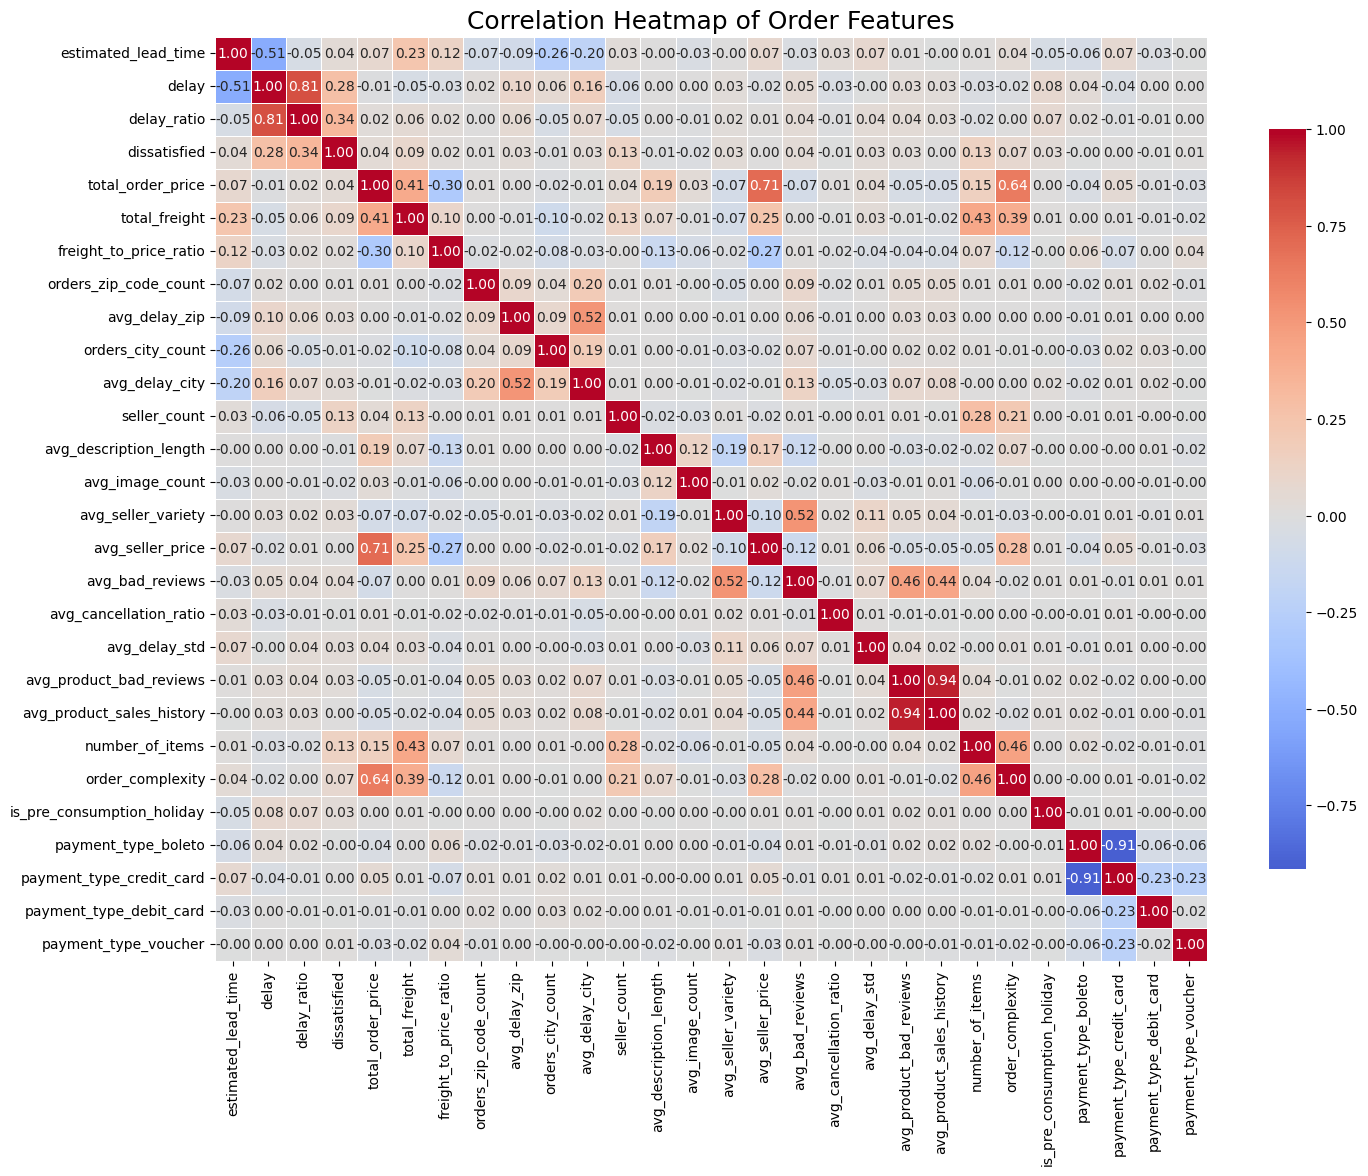

In [178]:
# I examine the correlation to get a better understanding of how my variables relate to each other

# Drop datetime column
df_corr = df.drop(columns=["order_estimated_delivery_date"])

# Convert booleans to integers so they appear in correlation
df_corr = df_corr.astype({col: int for col in df_corr.select_dtypes("bool").columns})

# Compute correlation matrix
corr = df_corr.corr()

# Plot full heatmap (no mask)
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Order Features", fontsize=18)

In [179]:
# To determine which will be our predictors in our model and which will be our target
# variable I obtain the column names

df.columns

Index(['order_estimated_delivery_date', 'estimated_lead_time', 'delay',
       'delay_ratio', 'dissatisfied', 'total_order_price', 'total_freight',
       'freight_to_price_ratio', 'orders_zip_code_count', 'avg_delay_zip',
       'orders_city_count', 'avg_delay_city', 'seller_count',
       'avg_description_length', 'avg_image_count', 'avg_seller_variety',
       'avg_seller_price', 'avg_bad_reviews', 'avg_cancellation_ratio',
       'avg_delay_std', 'avg_product_bad_reviews', 'avg_product_sales_history',
       'number_of_items', 'order_complexity', 'is_pre_consumption_holiday',
       'payment_type_boleto', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_voucher'],
      dtype='object')

In [180]:
# We test for a first version of the model using all the predictors
# -----------------------------
# 1. Define target and features
# -----------------------------
target = 'dissatisfied'   # already encoded as binary (0/1)

features = ['estimated_lead_time', 'delay',
       'delay_ratio', 'total_order_price', 'total_freight',
       'freight_to_price_ratio', 'orders_zip_code_count', 'avg_delay_zip',
       'orders_city_count', 'avg_delay_city', 'seller_count',
       'avg_description_length', 'avg_image_count', 'avg_seller_variety',
       'avg_seller_price', 'avg_bad_reviews', 'avg_cancellation_ratio',
       'avg_delay_std', 'avg_product_bad_reviews', 'avg_product_sales_history',
       'number_of_items', 'order_complexity', 'is_pre_consumption_holiday',
       'payment_type_boleto', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_voucher']

X = df[features]
y = df[target]


# -----------------------------
# 2. Define models and thresholds
# -----------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=75, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, is_unbalance=True)
}

thresholds = {
    "Decision Tree": 0.50,
    "Random Forest": 0.50,
    "XGBoost": 0.50,
    "LightGBM": 0.50,
}

results = {}

# -----------------------------
# 3. Define CV strategy
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

# -----------------------------
# 4. Loop through models
# -----------------------------
for name, model in models.items():
    # Get cross-validated predicted probabilities
    y_pred_proba = cross_val_predict(model, X, y, cv=cv,
                                     method="predict_proba")[:, 1]
    threshold = thresholds[name]
    y_pred = (y_pred_proba > threshold).astype(int)

    # Metrics
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    sens = recall_score(y, y_pred)  # sensitivity
    spec = recall_score(y, y_pred, pos_label=0)  # specificity
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_proba)
    pr_auc = average_precision_score(y, y_pred_proba)  # <-- Precision–Recall AUC

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Sensitivity": sens,
        "Specificity": spec,
        "F1-score": f1,
        "ROC AUC": auc,
        "PR AUC": pr_auc
    }

# -----------------------------
# 5. Print metrics
# -----------------------------
for name, metrics in results.items():
    print(f"\n{name} (Threshold: {thresholds[name]})")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")



[LightGBM] [Info] Number of positive: 9798, number of negative: 60445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3900
[LightGBM] [Info] Number of data points in the train set: 70243, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139487 -> initscore=-1.819556
[LightGBM] [Info] Start training from score -1.819556
[LightGBM] [Info] Number of positive: 9798, number of negative: 60445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3894
[LightGBM] [Info] Number of data points in the train set: 70243, number of used features: 27
[LightGBM] [Info] [b

In [181]:
# We iterate across the variables to determine which variables contribute less to the PR AUC of the model
# that had the best performance (LightGBM).

results = []

for feat in features:
    # Drop one feature at a time
    X_subset = X.drop(columns=[feat])
    model = LGBMClassifier(random_state=42, is_unbalance=True)
    
    # Cross-validation Precision–Recall AUC (average precision)
    pr_auc = cross_val_score(model, X_subset, y, cv=5, scoring="average_precision").mean()
    
    results.append({
        'feature_removed': feat,
        'pr_auc': pr_auc
    })

# Create DataFrame sorted by PR AUC
ablation_df = pd.DataFrame(results).sort_values('pr_auc', ascending=False)
print(ablation_df)



[LightGBM] [Info] Number of positive: 9798, number of negative: 60445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3820
[LightGBM] [Info] Number of data points in the train set: 70243, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139487 -> initscore=-1.819556
[LightGBM] [Info] Start training from score -1.819556
[LightGBM] [Info] Number of positive: 9798, number of negative: 60445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3814
[LightGBM] [Info] Number of data points in the train set: 70243, number of used features: 26
[LightGBM] [Info] [b

In [182]:
# We test for a second version of the model LightGBM using the same predictors as in the first model
# but excluding 'order_complexity' as these was the variable that according to the loop contributed
# the least to the PR AUC.

# -----------------------------
# 1. Define target and features
# -----------------------------
target = 'dissatisfied'   # already encoded as binary (0/1)

all_features = ['estimated_lead_time', 'delay',
       'delay_ratio', 'total_order_price', 'total_freight',
       'freight_to_price_ratio', 'orders_zip_code_count', 'avg_delay_zip',
       'orders_city_count', 'avg_delay_city', 'seller_count',
       'avg_description_length', 'avg_image_count', 'avg_seller_variety',
       'avg_seller_price', 'avg_bad_reviews', 'avg_cancellation_ratio',
       'avg_delay_std', 'avg_product_bad_reviews', 'avg_product_sales_history',
       'number_of_items', 'order_complexity', 'is_pre_consumption_holiday',
       'payment_type_boleto', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_voucher']

# choose which features to exclude
exclude = ['order_complexity']   

features = [f for f in all_features if f not in exclude]

X = df[features]
y = df[target]

# -----------------------------
# 2. Define LightGBM model
# -----------------------------
model = LGBMClassifier(random_state=42, is_unbalance=True)
threshold = 0.50

# -----------------------------
# 3. Cross-validation
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
y_pred = (y_pred_proba > threshold).astype(int)

# -----------------------------
# 4. Metrics
# -----------------------------
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
sens = recall_score(y, y_pred)  # sensitivity
spec = recall_score(y, y_pred, pos_label=0)  # specificity
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_pred_proba)
pr_auc = average_precision_score(y, y_pred_proba)

print("\nLightGBM (Threshold: 0.50)")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Sensitivity: {sens:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

[LightGBM] [Info] Number of positive: 9798, number of negative: 60445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3645
[LightGBM] [Info] Number of data points in the train set: 70243, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139487 -> initscore=-1.819556
[LightGBM] [Info] Start training from score -1.819556
[LightGBM] [Info] Number of positive: 9798, number of negative: 60445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 70243, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139487 -> initscore=-1.819556
[Lig

[LightGBM] [Info] Number of positive: 9798, number of negative: 60445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3900
[LightGBM] [Info] Number of data points in the train set: 70243, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139487 -> initscore=-1.819556
[LightGBM] [Info] Start training from score -1.819556
[LightGBM] [Info] Number of positive: 9798, number of negative: 60445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3894
[LightGBM] [Info] Number of data points in the train set: 70243, number of used features: 27
[LightGBM] [Info] [b

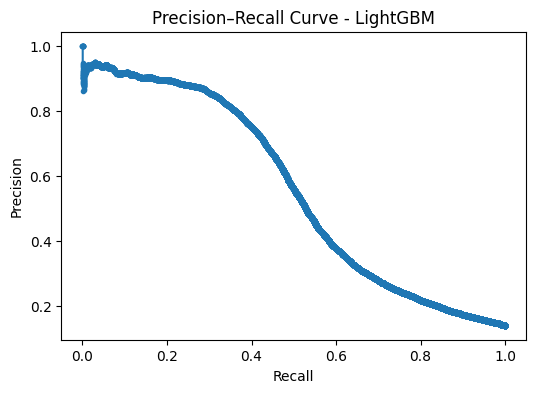


LightGBM (Threshold: 0.35)
Accuracy: 0.6395
Precision: 0.2437
Sensitivity (Recall): 0.7537
Specificity: 0.6210
F1-score: 0.3683
AUC: 0.7824
PR AUC: 0.5565


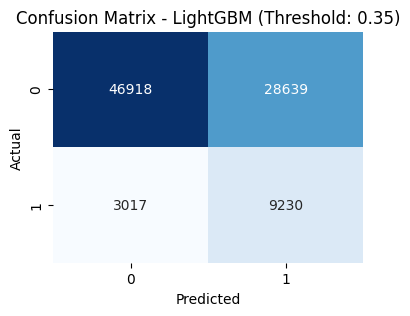


LightGBM (Threshold: 0.50)
Accuracy: 0.8440
Precision: 0.4514
Sensitivity (Recall): 0.5514
Specificity: 0.8914
F1-score: 0.4964
AUC: 0.7824
PR AUC: 0.5565


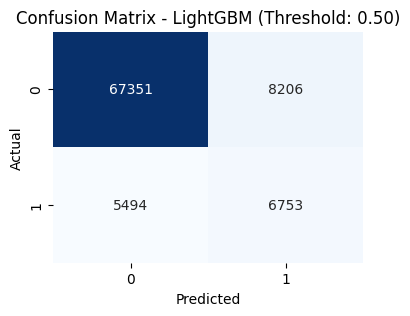


LightGBM (Threshold: 0.80)
Accuracy: 0.8978
Precision: 0.7548
Sensitivity (Recall): 0.3963
Specificity: 0.9791
F1-score: 0.5198
AUC: 0.7824
PR AUC: 0.5565


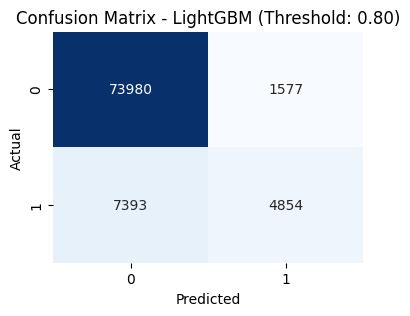

In [183]:
# We fit our final model. As dropping the variable 'order_complexity' actually hurt our model performance although the change was negligible
# we include the variable again because we are not concerned by the model explainability as our goal is to maximize precision-recall.
# We  test for the precision recall tradeoff and plot the confusion matrix.

# -----------------------------
# 1. Define target and features
# -----------------------------
target = 'dissatisfied'

all_features = ['estimated_lead_time', 'delay',
       'delay_ratio', 'total_order_price', 'total_freight',
       'freight_to_price_ratio', 'orders_zip_code_count', 'avg_delay_zip',
       'orders_city_count', 'avg_delay_city', 'seller_count',
       'avg_description_length', 'avg_image_count', 'avg_seller_variety',
       'avg_seller_price', 'avg_bad_reviews', 'avg_cancellation_ratio',
       'avg_delay_std', 'avg_product_bad_reviews', 'avg_product_sales_history',
       'number_of_items', 'order_complexity', 'is_pre_consumption_holiday',
       'payment_type_boleto', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_voucher']


X = df[all_features]
y = df[target]

# -----------------------------
# 2. Define model and thresholds
# -----------------------------
model = LGBMClassifier(random_state=42, is_unbalance=True)
thresholds = [0.35, 0.50, 0.80]  # low-impact, balanced, high-impact

# -----------------------------
# 3. Cross-validation
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]

# -----------------------------
# 4. Precision–Recall Curve
# -----------------------------
precisions, recalls, pr_thresholds = precision_recall_curve(y, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - LightGBM")
plt.show()

# -----------------------------
# 5. Evaluate each threshold
# -----------------------------
for threshold in thresholds:
    y_pred = (y_pred_proba > threshold).astype(int)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    sens = recall_score(y, y_pred)
    spec = recall_score(y, y_pred, pos_label=0)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_proba)
    pr_auc = average_precision_score(y, y_pred_proba)

    print(f"\nLightGBM (Threshold: {threshold:.2f})")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Sensitivity (Recall): {sens:.4f}")
    print(f"Specificity: {spec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Confusion Matrix - LightGBM (Threshold: {threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()